# Exploring the signal
The point of this notebook is,
- to explore inclusive signal events `GluGluHToWW_Pt-200ToInf_M-125`
- to explore our basic definitions of the `candidatelep` and the `candidatefj`
- to explore how our selections affect the signal

In [1]:
import argparse
import json
import os
import pathlib
import pickle as pkl
import shutil
import sys
import time
import warnings
from collections import defaultdict
from typing import List, Optional, Union

import awkward as ak
import hist as hist2
import matplotlib.pyplot as plt
import mplhep as hep
import numpy as np
import pandas as pd
import pyarrow as pa
import pyarrow.parquet as pq
import uproot
from coffea import nanoevents, processor
from coffea.analysis_tools import PackedSelection, Weights
from coffea.nanoevents import BaseSchema, NanoAODSchema, NanoEventsFactory
from coffea.nanoevents.methods import candidate, vector
from coffea.nanoevents.methods.nanoaod import FatJetArray, GenParticleArray

warnings.filterwarnings("ignore", message="Found duplicate branch ")
warnings.filterwarnings("ignore", category=DeprecationWarning)
np.seterr(invalid="ignore")

sys.path.append("../")
plt.style.use(hep.style.CMS)

/opt/anaconda3/envs/coffea-env/lib/python3.8/site-packages/pandas/core/computation/expressions.py:20: UserWarning: Pandas requires version '2.7.3' or newer of 'numexpr' (version '2.7.1' currently installed).
  from pandas.core.computation.check import NUMEXPR_INSTALLED


In [2]:
def build_p4(cand):
    """
    Build a p4 vector object from an awkward array.
    """
    return ak.zip(
        {
            "pt": cand.pt,
            "eta": cand.eta,
            "phi": cand.phi,
            "mass": cand.mass,
#             "charge": cand.charge,
        },
        with_name="PtEtaPhiMCandidate",
        behavior=candidate.behavior,
    )

def get_pid_mask(
    genparts: GenParticleArray,
    pdgids: Union[int, list],
    ax: int = 2,
    byall: bool = True,
) -> ak.Array:
    """
    Get selection mask for gen particles matching any of the pdgIds in ``pdgids``.
    If ``byall``, checks all particles along axis ``ax`` match.
    """
    gen_pdgids = abs(genparts.pdgId)

    if type(pdgids) == list:
        mask = gen_pdgids == pdgids[0]
        for pdgid in pdgids[1:]:
            mask = mask | (gen_pdgids == pdgid)
    else:
        mask = gen_pdgids == pdgids

    return ak.all(mask, axis=ax) if byall else mask

# Load a rootfile

In [3]:
! ls ../rootfiles/GluGluHToWW_Pt-200ToInf_M-125

nano_mc2017_1.root nano_mc2017_2.root nano_mc2017_3.root


In [4]:
### schema
nanoevents.PFNanoAODSchema.mixins["PFCands"] = "PFCand"
nanoevents.PFNanoAODSchema.mixins["SV"] = "PFCand"

# load a ggF root file into coffea-friendly NanoAOD structure
import uproot
f = uproot.open(f"../rootfiles/GluGluHToWW_Pt-200ToInf_M-125/nano_mc2017_3.root")
num = f['Events'].num_entries   ### checks number of events per file 
print(f'number of events per file: {num}')

events = nanoevents.NanoEventsFactory.from_root(f, "Events", schemaclass=nanoevents.PFNanoAODSchema).events()

number of events per file: 27000


/opt/anaconda3/envs/coffea-env/lib/python3.8/site-packages/coffea/nanoevents/schemas/nanoaod.py:201: RuntimeWarning: Missing cross-reference index for GenFatJetCands_jetIdx => GenJetAK8
  warnings.warn(
/opt/anaconda3/envs/coffea-env/lib/python3.8/site-packages/coffea/nanoevents/schemas/nanoaod.py:201: RuntimeWarning: Missing cross-reference index for GenFatJetCands_pFCandsIdx => GenCands
  warnings.warn(
/opt/anaconda3/envs/coffea-env/lib/python3.8/site-packages/coffea/nanoevents/schemas/nanoaod.py:201: RuntimeWarning: Missing cross-reference index for GenFatJetSVs_jetIdx => GenJetAK8
  warnings.warn(
/opt/anaconda3/envs/coffea-env/lib/python3.8/site-packages/coffea/nanoevents/schemas/nanoaod.py:201: RuntimeWarning: Missing cross-reference index for GenFatJetSVs_sVIdx => SV
  warnings.warn(
/opt/anaconda3/envs/coffea-env/lib/python3.8/site-packages/coffea/nanoevents/schemas/nanoaod.py:201: RuntimeWarning: Missing cross-reference index for GenJetCands_jetIdx => GenJet
  warnings.warn(


# Get `candidatelep` and `candidatefj`

In [5]:
leptons = ak.concatenate([events.Muon, events.Electron], axis=1)
print(f"Events with a lepton: {len(ak.flatten(ak.firsts(leptons), axis=0))}")

# muon pt > 28 and electron pt > 38
good_muons = (events.Muon.pt > 28)
good_electrons = (events.Electron.pt > 38)
leptons = ak.concatenate([events.Muon[good_muons], events.Electron[good_electrons]], axis=1)
print(f"Events with pT(muon)>28 and pT(electron)>38: {len(ak.flatten(ak.firsts(leptons), axis=0))}")

Events with a lepton: 22636
Events with pT(muon)>28 and pT(electron)>38: 12181


In [6]:
### get candidate lepton
nevents = len(events)

# define muon objects
good_muons = (
    (events.Muon.pt > 28)
    & (np.abs(events.Muon.eta) < 2.4)
    & (np.abs(events.Muon.dz) < 0.1)
    & (np.abs(events.Muon.dxy) < 0.05)
    & (events.Muon.sip3d <= 4.0)
    & events.Muon.mediumId
)

# define electron objects
good_electrons = (
    (events.Electron.pt > 38)
    & ((np.abs(events.Electron.eta) < 1.44) | (np.abs(events.Electron.eta) > 1.57))
    & (np.abs(events.Electron.dz) < 0.1)
    & (np.abs(events.Electron.dxy) < 0.05)
    & (events.Electron.sip3d <= 4.0)
    & (events.Electron.mvaFall17V2noIso_WP90)
)

# concatenate muons and electrons
goodleptons = ak.concatenate([events.Muon[good_muons], events.Electron[good_electrons]], axis=1)

# pick the leading lepton as our candidatelep
goodleptons = goodleptons[ak.argsort(goodleptons.pt, ascending=False)]
candidatelep = ak.firsts(goodleptons)

candidatelep_p4 = build_p4(candidatelep)    # build p4 to be able to compute delta_r with jet

print(f"Events with a candidatelep: {len(ak.flatten(candidatelep, axis=0))}")
candidatelep

Events with a candidatelep: 6728


<Array [Muon, None, None, ... None, None, None] type='27000 * ?union[muon, elect...'>

(array([6189.,    0.,    0.,    0.,    0.,    0.,    0.,    0.,    0.,
         539.]),
 array([1. , 1.1, 1.2, 1.3, 1.4, 1.5, 1.6, 1.7, 1.8, 1.9, 2. ]),
 <BarContainer object of 10 artists>)

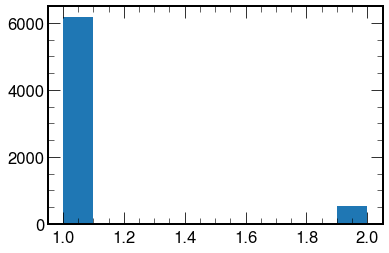

In [14]:
plt.hist(ak.num(goodleptons)[ak.num(goodleptons)!=0])

(exptext: Custom Text(0.0, 1, 'CMS'),
 expsuffix: Custom Text(0.0, 1.005, 'Work in Progress'))

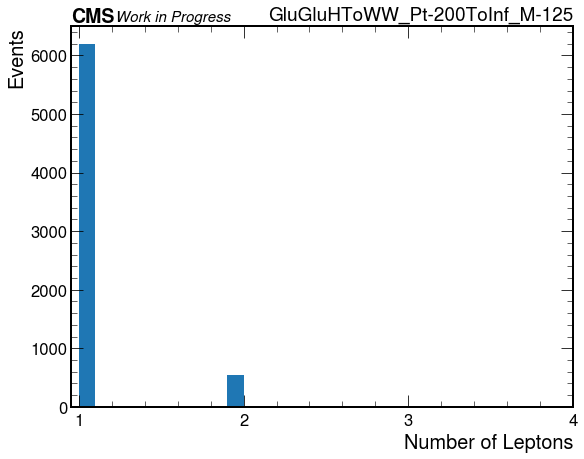

In [15]:
plt.rcParams.update({"font.size": 20})
from matplotlib.colors import LogNorm
fig, ax = plt.subplots(figsize=(9, 7))

plt.hist(ak.num(goodleptons)[ak.num(goodleptons)!=0])

ax.set_xticks([1,2,3,4])
# ax.set_xlim(40,400)
# ax.set_ylim(0,10)
ax.set_xlabel(r"Number of Leptons");
ax.set_ylabel(r"Events");
hep.cms.lumitext(
    "GluGluHToWW_Pt-200ToInf_M-125", ax=ax, fontsize=20
)
hep.cms.text("Work in Progress", ax=ax, fontsize=15)
# ax.set_yscale("log")

In [19]:
jets = events.Jet

In [55]:
# define good_jets
jets = events.Jet
n_jets = ak.num(jets)


good_jets = (
    (jets.pt > 30)
    & (abs(jets.eta) < 2.5)
    & jets.isTight
    & (jets.puId > 0)
)
good_jets = jets[good_jets]

ht = ak.sum(good_jets.pt, axis=1)

# define good_fatjets
fatjets = events.FatJet

good_fatjets = (
    (fatjets.pt > 200)
    & (abs(fatjets.eta) < 2.5)
    & fatjets.isTight
)
n_fatjets = ak.sum(good_fatjets_, axis=1)

good_fatjets = fatjets[good_fatjets]

# sort the fatjets by closest to the candidatelep
sorted_indices = ak.argsort(candidatelep_p4.delta_r(good_fatjets), ascending=True)

# # # select the candidatefj to be the one closest to the candidatelep_p4
# candidatefj = ak.firsts(good_fatjets[sorted_indices])
# second_fj = ak.firsts(good_fatjets[sorted_indices][:, 1:2])

### useful for the tagger
candidatefj_indx = sorted_indices[:, 0:1]
second_fj_indx = sorted_indices[:, 1:2]

candidatefj = ak.firsts(good_fatjets[candidatefj_indx])
second_fj = ak.firsts(good_fatjets[second_fj_indx])

print(f"Events with a candidatefj: {len(ak.flatten(candidatefj, axis=0))}")
print(f"Events with a second_fj: {len(ak.flatten(second_fj, axis=0))}")

candidatefj

Events with a candidatefj: 5615
Events with a second_fj: 2727


<FatJetArray [FatJet, None, None, ... None, None] type='27000 * ?fatJet'>

In [418]:
# define good_fatjets AK15
fatjets_AK15 = events.FatJetAK15

good_fatjets_AK15 = (
    (fatjets_AK15.pt > 200)
    & (abs(fatjets_AK15.eta) < 2.5)
#     & fatjets_AK15.isTight
)
n_fatjets_AK15 = ak.sum(good_fatjets_AK15, axis=1)

good_fatjets_AK15 = fatjets_AK15[good_fatjets_AK15]

# sort the fatjets by closest to the candidatelep
sorted_indices_AK15 = ak.argsort(candidatelep_p4.delta_r(good_fatjets_AK15), ascending=True)

# select the candidatefj to be the one closest to the candidatelep_p4
### useful for the tagger
candidatefj_AK15_indx = sorted_indices_AK15[:, 0:1]
second_fj_AK15_indx = sorted_indices_AK15[:, 1:2]

candidatefj_AK15 = ak.firsts(good_fatjets_AK15[candidatefj_AK15_indx])
second_fj_AK15 = ak.firsts(good_fatjets_AK15[second_fj_AK15_indx])

print(f"Events with a candidatefj_AK15: {len(ak.flatten(candidatefj_AK15, axis=0))}")
print(f"Events with a second_fj_AK15: {len(ak.flatten(second_fj_AK15, axis=0))}")

candidatefj_AK15

Events with a candidatefj_AK15: 6254
Events with a second_fj_AK15: 3745


<NanoCollectionArray [... None] type='27000 * ?struct[["ParticleNetMD_probQCD", ...'>

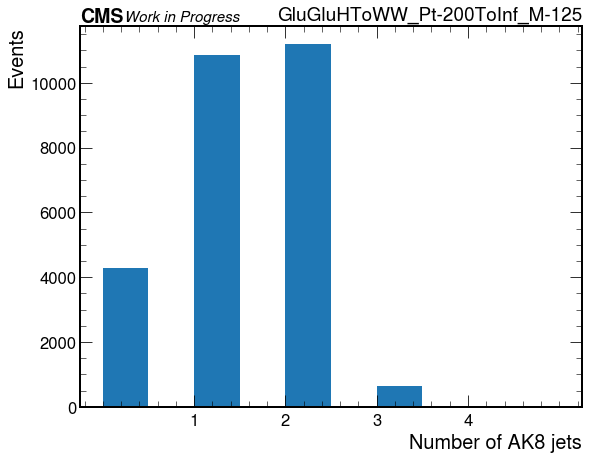

In [47]:
plt.rcParams.update({"font.size": 20})
from matplotlib.colors import LogNorm
fig, ax = plt.subplots(figsize=(9, 7))

plt.hist(n_fatjets)

ax.set_xticks([1,2,3,4])
# ax.set_xlim(40,400)
# ax.set_ylim(0,10)
ax.set_xlabel(r"Number of AK8 jets");
ax.set_ylabel(r"Events");
hep.cms.lumitext(
    "GluGluHToWW_Pt-200ToInf_M-125", ax=ax, fontsize=20
)
hep.cms.text("Work in Progress", ax=ax, fontsize=15)
# ax.set_yscale("log")
plt.savefig(f"/Users/fmokhtar/Desktop/hww/num_fatjets.pdf", bbox_inches='tight')

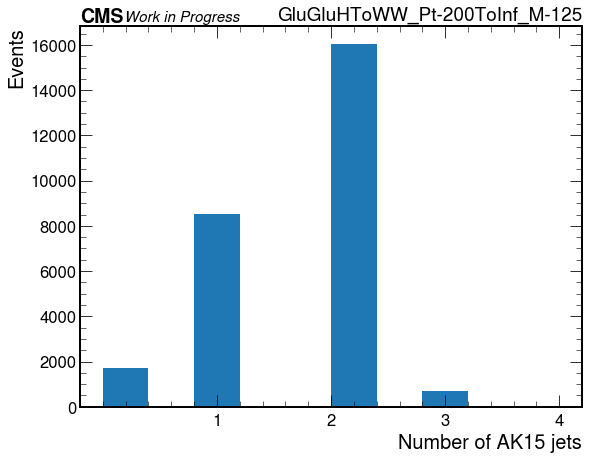

In [48]:
from matplotlib.colors import LogNorm
fig, ax = plt.subplots(figsize=(9, 7))

plt.hist(n_fatjets_AK15)

ax.set_xticks([1,2,3,4])
# ax.set_xlim(40,400)
# ax.set_ylim(0,10)
ax.set_xlabel(r"Number of AK15 jets");
ax.set_ylabel(r"Events");
hep.cms.lumitext(
    "GluGluHToWW_Pt-200ToInf_M-125", ax=ax, fontsize=20
)
hep.cms.text("Work in Progress", ax=ax, fontsize=15)
# ax.set_yscale("log")
plt.savefig(f"/Users/fmokhtar/Desktop/hww/num_fatjets_AK15.pdf", bbox_inches='tight')

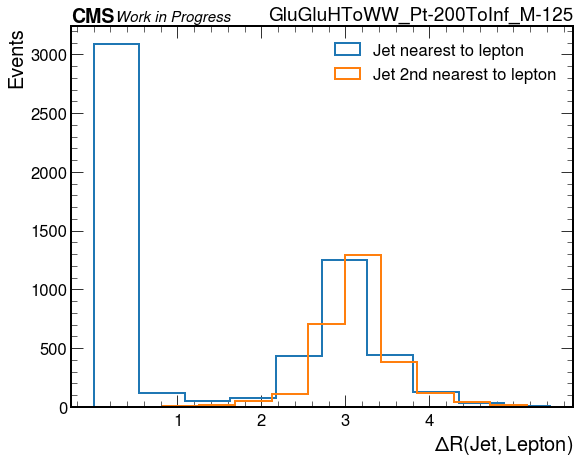

In [49]:
from matplotlib.colors import LogNorm
fig, ax = plt.subplots(figsize=(9, 7))

plt.hist(ak.flatten(candidatelep_p4.delta_r(candidatefj), axis=0), label=r"Jet nearest to lepton", histtype="step", linewidth=2)
plt.hist(ak.flatten(candidatelep_p4.delta_r(second_fj), axis=0), label=r"Jet 2nd nearest to lepton", histtype="step", linewidth=2)

ax.set_xticks([1,2,3,4])
# ax.set_xlim(40,400)
# ax.set_ylim(0,10)
ax.legend()
ax.set_xlabel(r"$\Delta R(Jet,Lepton)$");
ax.set_ylabel(r"Events");
hep.cms.lumitext(
    "GluGluHToWW_Pt-200ToInf_M-125", ax=ax, fontsize=20
)
hep.cms.text("Work in Progress", ax=ax, fontsize=15)
# ax.set_yscale("log")
plt.savefig(f"/Users/fmokhtar/Desktop/hww/1d-deltaR_first_second_jets.pdf", bbox_inches='tight')

In [ ]:
#### check the highest pT Jet vs our selected Jet?
### how often is your candidate jet is the highest pT jet?

# Get the higgs

In [50]:
HIGGS_PDGID = 25
GEN_FLAGS = ["fromHardProcess", "isLastCopy"]
higgs = events.GenPart[get_pid_mask(events.GenPart, HIGGS_PDGID, byall=False) * events.GenPart.hasFlags(GEN_FLAGS)]

# make sure that each events has one and only one higgs
assert ak.sum(ak.num(higgs)!=1)==0

higgs = ak.firsts(higgs)

print(f"Number of events: {nevents}")
for pt in np.linspace(50, 600, 12):
    print(f"Number of events with pt(Higgs)>{pt:.0f}: {ak.sum(higgs.pt>pt)}")

Number of events: 27000
Number of events with pt(Higgs)>50: 26938
Number of events with pt(Higgs)>100: 26693
Number of events with pt(Higgs)>150: 26008
Number of events with pt(Higgs)>200: 22162
Number of events with pt(Higgs)>250: 11999
Number of events with pt(Higgs)>300: 5881
Number of events with pt(Higgs)>350: 3020
Number of events with pt(Higgs)>400: 1609
Number of events with pt(Higgs)>450: 875
Number of events with pt(Higgs)>500: 488
Number of events with pt(Higgs)>550: 297
Number of events with pt(Higgs)>600: 167


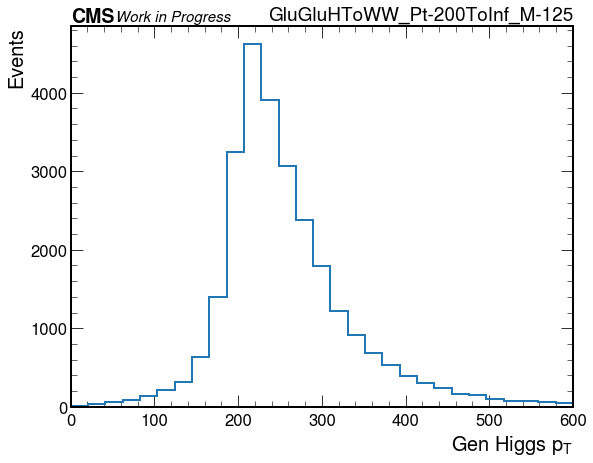

In [51]:
# gen higgs pt
plt.rcParams.update({"font.size": 20})

fig, ax = plt.subplots(figsize=(9, 7))

ax.hist(higgs.pt, histtype="step", linewidth=2, bins=np.linspace(0,600,30))

ax.set_xlim(0, 600)
# ax.legend(title=f"ggF samples")
ax.set_ylabel(r"Events"); 
ax.set_xlabel(r"Gen Higgs $p_T$");
hep.cms.lumitext(
    "GluGluHToWW_Pt-200ToInf_M-125", ax=ax, fontsize=20
)
hep.cms.text("Work in Progress", ax=ax, fontsize=15)
# ax.set_yscale("log")

plt.savefig(f"/Users/fmokhtar/Desktop/hww/gen_higgs_pt.pdf", bbox_inches='tight')

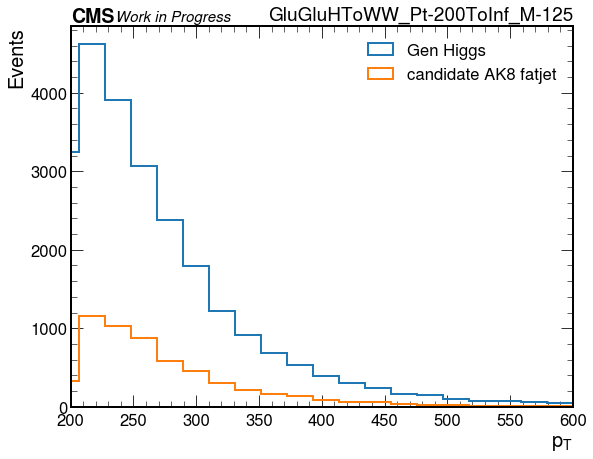

In [52]:
plt.rcParams.update({"font.size": 20})

fig, ax = plt.subplots(figsize=(9, 7))

ax.hist(higgs.pt, label=r"Gen Higgs", histtype="step", linewidth=2, bins=np.linspace(0,600,30))
ax.hist(ak.flatten(candidatefj.pt, axis=0), label="candidate AK8 fatjet", histtype="step", linewidth=2, bins=np.linspace(0,600,30))

ax.set_xlim(200, 600)
ax.legend()
ax.set_ylabel(r"Events"); 
ax.set_xlabel(r"$p_T$");
hep.cms.lumitext(
    "GluGluHToWW_Pt-200ToInf_M-125", ax=ax, fontsize=20
)
hep.cms.text("Work in Progress", ax=ax, fontsize=15)
# ax.set_yscale("log")

plt.savefig(f"/Users/fmokhtar/Desktop/hww/gen_higgs_pt_jet_pt.pdf", bbox_inches='tight')

In [54]:
### only ~40% decays of HWW are semi-leptonic (have candidatelep)
events_with_candidatelep = ~ak.to_numpy(candidatelep.pt).mask
print(f"Events with candidatelep: {events_with_candidatelep.sum()}")

# why do some events have a candidatelep but not candidatejet?
events_with_candidatefj = ~ak.to_numpy(candidatefj.pt).mask
print(f"Events with candidatefj: {events_with_candidatefj.sum()}")

lep_and_fj = (events_with_candidatelep & events_with_candidatefj)

Events with candidatelep: 6728
Events with candidatefj: 5615


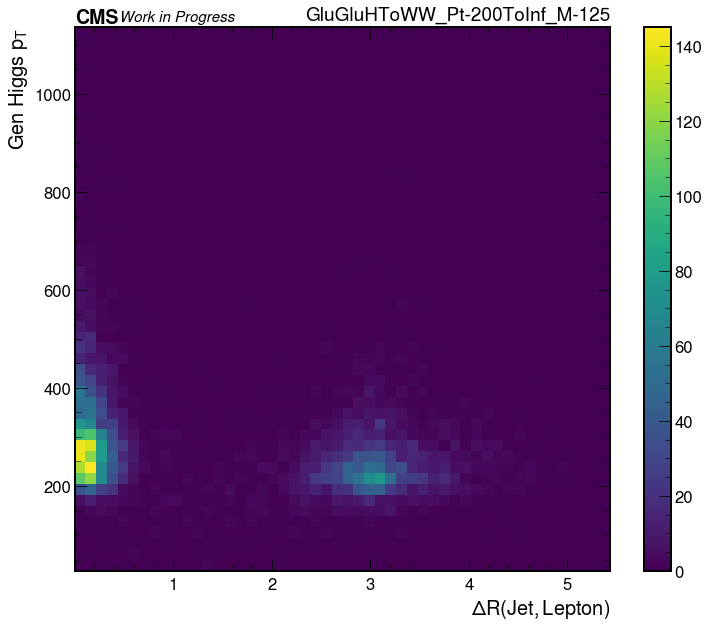

In [55]:
### plot those events with both candidatelep and candidatefj
from matplotlib.colors import LogNorm
fig, ax = plt.subplots(figsize=(12, 10))

X = ak.to_numpy(candidatefj[lep_and_fj].delta_r(candidatelep_p4[lep_and_fj])).data
Y = ak.to_numpy(higgs[lep_and_fj].pt).data

plt.hist2d(
    X,
    Y,
#     norm=LogNorm(),
    bins=[50,50]
      )

# ax.set_ylim(0,600)
# ax.set_ylim(0,10)
ax.set_xlabel(r"$\Delta R(Jet, Lepton)$");
ax.set_ylabel(r"Gen Higgs $p_T$");
plt.colorbar()
hep.cms.lumitext(
    "GluGluHToWW_Pt-200ToInf_M-125", ax=ax, fontsize=20
)
hep.cms.text("Work in Progress", ax=ax, fontsize=15)
# ax.set_yscale("log")
plt.savefig(f"/Users/fmokhtar/Desktop/hww/2d-gen_pt_dR.pdf", bbox_inches='tight')

## Events with `candidatelep` & `candidatefj`

In [56]:
lep_and_fj = (events_with_candidatelep & events_with_candidatefj)
lep_and_fj.sum()

5615

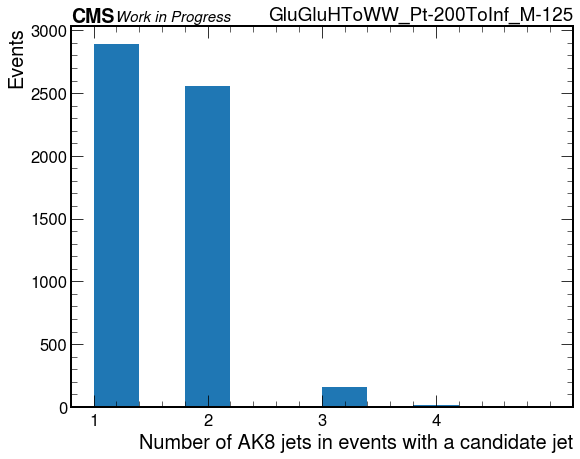

In [57]:
from matplotlib.colors import LogNorm
fig, ax = plt.subplots(figsize=(9, 7))

plt.hist(n_fatjets[lep_and_fj])

ax.set_xticks([1,2,3,4])
# ax.set_xlim(40,400)
# ax.set_ylim(0,10)
ax.set_xlabel(r"Number of AK8 jets in events with a candidate jet");
ax.set_ylabel(r"Events");
hep.cms.lumitext(
    "GluGluHToWW_Pt-200ToInf_M-125", ax=ax, fontsize=20
)
hep.cms.text("Work in Progress", ax=ax, fontsize=15)
# ax.set_yscale("log")
plt.savefig(f"/Users/fmokhtar/Desktop/hww/num_fatjets_in_events_with_candidatefj.pdf", bbox_inches='tight')

## Events with `candidatelep` but no `candidate fj`

In [58]:
lep_but_no_fj = (events_with_candidatelep & ~events_with_candidatefj)
lep_but_no_fj.sum()

1113

# Tagger

In [493]:
# functions here are copied from `run_tagger_inference.py`
# import modules to build the tagger inputs
import sys
sys.path.append("../boostedhiggs/")
from get_tagger_inputs import get_pfcands_features, get_svs_features

from typing import Dict

import tritonclient.grpc as triton_grpc
import tritonclient.http as triton_http
from tqdm import tqdm

def postprocess_tagger_output(tagger_outputs):
    output_names = [x.replace("label_", "prob").replace("_", "") for x in tagger_vars["output_names"]]

    pnet_vars = {}
    if pversion == "ParticleNet":  # missing softmax for that model (unfortunately)
        import scipy

        # last index is mass regression
        tagger_outputs[:, :-1] = scipy.special.softmax(tagger_outputs[:, :-1], axis=1)

    for i, output_name in enumerate(output_names):
        pnet_vars[f"fj_{pversion}_{output_name}"] = tagger_outputs[:, i]

    # if model is ParT, add pku vars of that jet. MUST BE pf_nano v2_4
    if pversion == "ParT_noreg":
        jet = ak.firsts(events[fatjet_label][fj_idx_lep])
        pku_vars = {
            f"fj_PKU_{pversion}_{output_name}": jet[f"inclParTMDV1_{output_name}"] for output_name in output_names
        }
        pku_vars[f"fj_PKU_{pversion}_mass"] = jet["inclParTMDV1_mass"]

        pnet_vars = {**pnet_vars, **pku_vars}
    return pnet_vars

# adapted from https://github.com/lgray/hgg-coffea/blob/triton-bdts/src/hgg_coffea/tools/chained_quantile.py
class wrapped_triton:
    def __init__(self, model_url: str, batch_size: int, out_name: str = "softmax__0") -> None:
        fullprotocol, location = model_url.split("://")
        _, protocol = fullprotocol.split("+")
        address, model, version = location.split("/")

        self._protocol = protocol
        self._address = address
        self._model = model
        self._version = version

        self._batch_size = batch_size
        self._out_name = out_name

    def __call__(self, input_dict: Dict[str, np.ndarray]) -> np.ndarray:
        if self._protocol == "grpc":
            client = triton_grpc.InferenceServerClient(url=self._address, verbose=False)
            triton_protocol = triton_grpc
        elif self._protocol == "http":
            client = triton_http.InferenceServerClient(
                url=self._address,
                verbose=False,
                concurrency=12,
            )
            triton_protocol = triton_http
        else:
            raise ValueError(f"{self._protocol} does not encode a valid protocol (grpc or http)")

        # manually split into batches for gpu inference
        input_size = input_dict[list(input_dict.keys())[0]].shape[0]
        # print(f"size of input (number of events) = {input_size}")

        outs = [
            self._do_inference(
                {key: input_dict[key][batch : batch + self._batch_size] for key in input_dict},
                triton_protocol,
                client,
            )
            for batch in tqdm(range(0, input_dict[list(input_dict.keys())[0]].shape[0], self._batch_size))
        ]

        return np.concatenate(outs) if input_size > 0 else outs

    def _do_inference(self, input_dict: Dict[str, np.ndarray], triton_protocol, client) -> np.ndarray:
        # Infer
        inputs = []

        for key in input_dict:
            input = triton_protocol.InferInput(key, input_dict[key].shape, "FP32")
            input.set_data_from_numpy(input_dict[key])
            inputs.append(input)

        output = triton_protocol.InferRequestedOutput(self._out_name)

        request = client.infer(
            self._model,
            model_version=self._version,
            inputs=inputs,
            outputs=[output],
        )

        return request.as_numpy(self._out_name)
    
tagger_resources_path = "../boostedhiggs/tagger_resources/"

# use this model
model_name = "ak8_MD_vminclv2ParT_manual_fixwrap"

# the different models we can use
pversion, out_name = {
    "05_10_ak8_ttbarwjets": ["PN_UCSD", "softmax__0"],
    "particlenet_hww_inclv2_pre2": ["ParticleNet", "output__0"],
    "particlenet_hww_inclv2_pre2_noreg": ["PN_v2_noreg", "softmax__0"],
    "ak8_MD_vminclv2ParT_manual_fixwrap": ["ParT_noreg", "softmax"],
    "ak8_MD_vminclv2ParT_manual_fixwrap_all_nodes": ["ParT", "softmax"],
}[model_name]   

with open(f"{tagger_resources_path}/triton_config_{model_name}.json") as f:
    triton_config = json.load(f)

with open(f"{tagger_resources_path}/{triton_config['model_name']}.json") as f:
    tagger_vars = json.load(f)
    
triton_model = wrapped_triton(triton_config["model_url"], triton_config["batch_size"], out_name=out_name)        

In [494]:
fatjet_label = "FatJet"
pfcands_label = "FatJetPFCands"
svs_label = "FatJetSVs"

### test for first and second fatjets
fatjets = [candidatefj_indx, second_fj_indx]

pnet_vars = {}

for i, fatjet_indx in enumerate(fatjets):
    print(f"Will run tagger for fatjet # {i}")
    # get pfcands
    pfcands_features = get_pfcands_features(tagger_vars, events[events_with_candidatefj], fatjet_indx[events_with_candidatefj], fatjet_label, pfcands_label)

    # get svs
    svs_features = get_svs_features(tagger_vars, events[events_with_candidatefj], fatjet_indx[events_with_candidatefj], fatjet_label, svs_label)

    # this is our input to the tagger
    feature_dict = {
        **pfcands_features,
        **svs_features,
    }

    tagger_inputs = []

    for input_name in tagger_vars["input_names"]:
        for key in tagger_vars[input_name]["var_names"]:
            np.expand_dims(feature_dict[key], 1)

    if out_name == "softmax":
        tagger_inputs = {
            f"{input_name}": np.concatenate(
                [np.expand_dims(feature_dict[key], 1) for key in tagger_vars[input_name]["var_names"]],
                axis=1,
            )
            for i, input_name in enumerate(tagger_vars["input_names"])
        }
    else:
        tagger_inputs = {
            f"{input_name}__{i}": np.concatenate(
                [np.expand_dims(feature_dict[key], 1) for key in tagger_vars[input_name]["var_names"]],
                axis=1,
            )
            for i, input_name in enumerate(tagger_vars["input_names"])
        }

    # run inference
    tagger_outputs = triton_model(tagger_inputs) 
    
    pnet_vars[f"fatjet{i}"] = postprocess_tagger_output(tagger_outputs)

Will run tagger for fatjet # 0


100%|██████████| 44/44 [01:37<00:00,  2.21s/it]


Will run tagger for fatjet # 1


100%|██████████| 44/44 [01:31<00:00,  2.08s/it]


In [498]:
# scores definition
hwwev = ["fj_PN_probHWqqWev0c", "fj_PN_probHWqqWev1c", "fj_PN_probHWqqWtauev0c", "fj_PN_probHWqqWtauev1c"]
hwwmv = ["fj_PN_probHWqqWmv0c", "fj_PN_probHWqqWmv1c", "fj_PN_probHWqqWtaumv0c", "fj_PN_probHWqqWtaumv1c"]
hwwhad = [
    "fj_PN_probHWqqWqq0c",
    "fj_PN_probHWqqWqq1c",
    "fj_PN_probHWqqWqq2c",
    "fj_PN_probHWqqWq0c",
    "fj_PN_probHWqqWq1c",
    "fj_PN_probHWqqWq2c",
    "fj_PN_probHWqqWtauhv0c",
    "fj_PN_probHWqqWtauhv1c",
]
sigs = hwwev + hwwmv + hwwhad
new_sig = [s.replace("PN", "ParT_noreg") for s in sigs]

# background
qcd = ["fj_PN_probQCDbb", "fj_PN_probQCDcc", "fj_PN_probQCDb", "fj_PN_probQCDc", "fj_PN_probQCDothers"]

tope = ["fj_PN_probTopbWev", "fj_PN_probTopbWtauev"]
topm = ["fj_PN_probTopbWmv", "fj_PN_probTopbWtaumv"]
tophad = ["fj_PN_probTopbWqq0c", "fj_PN_probTopbWqq1c", "fj_PN_probTopbWq0c", "fj_PN_probTopbWq1c", "fj_PN_probTopbWtauhv"]

top = tope + topm + tophad

inclusive_bkg = [b.replace("PN", "ParT_noreg") for b in qcd + tope + topm + tophad]

ParT_noreg_hww_score = {}
for fatjet in pnet_vars:

    num = 0
    for prob in new_sig:
        num += pnet_vars[fatjet][prob]
        
    deno = 0
    deno += num
    for prob in inclusive_bkg:
        deno += pnet_vars[fatjet][prob]
    
    ParT_noreg_hww_score[fatjet] = num/deno

In [499]:
# see this for the actual score we are using in the analysis

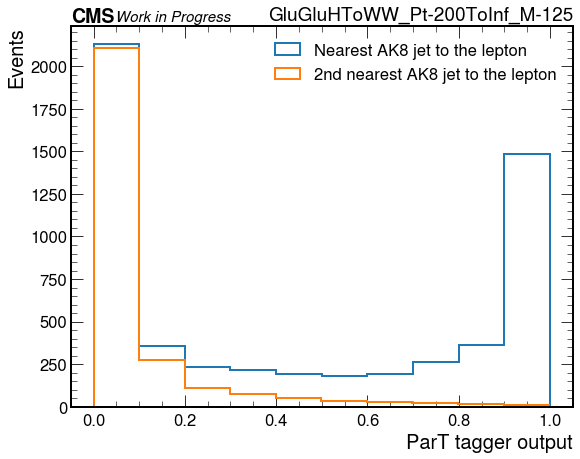

In [500]:
plt.rcParams.update({"font.size": 20})

label_dict = {
    "fatjet0": "Nearest AK8 jet to the lepton",
    "fatjet1": "2nd nearest AK8 jet to the lepton"
}

fig, ax = plt.subplots(figsize=(9, 7))

for fatjet in ParT_noreg_hww_score:
    ax.hist(ParT_noreg_hww_score[fatjet], label=label_dict[fatjet], histtype="step", linewidth=2)

ax.legend()
ax.set_ylabel(r"Events"); 
ax.set_xlabel(r"ParT tagger output");
hep.cms.lumitext(
    "GluGluHToWW_Pt-200ToInf_M-125", ax=ax, fontsize=20
)
hep.cms.text("Work in Progress", ax=ax, fontsize=15)
# ax.set_yscale("log")

plt.savefig(f"/Users/fmokhtar/Desktop/hww/ParT_1st_and_2nd_fj.pdf", bbox_inches='tight')

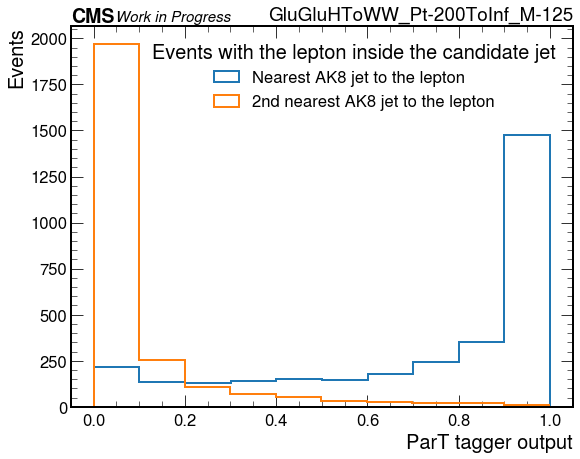

In [501]:
plt.rcParams.update({"font.size": 20})

label_dict = {
    "fatjet0": "Nearest AK8 jet to the lepton",
    "fatjet1": "2nd nearest AK8 jet to the lepton"
}

fig, ax = plt.subplots(figsize=(9, 7))

lep_inside_jet_events = (candidatefj.delta_r(candidatelep)<0.8)[events_with_candidatefj]

for fatjet in ParT_noreg_hww_score:
    ax.hist(ParT_noreg_hww_score[fatjet][lep_inside_jet_events], label=label_dict[fatjet], histtype="step", linewidth=2)

ax.legend(title="Events with the lepton inside the candidate jet")
ax.set_ylabel(r"Events"); 
ax.set_xlabel(r"ParT tagger output");
hep.cms.lumitext(
    "GluGluHToWW_Pt-200ToInf_M-125", ax=ax, fontsize=20
)
hep.cms.text("Work in Progress", ax=ax, fontsize=15)
# ax.set_yscale("log")

plt.savefig(f"/Users/fmokhtar/Desktop/hww/ParT_1st_and_2nd_fj_lep_inside_jet.pdf", bbox_inches='tight')

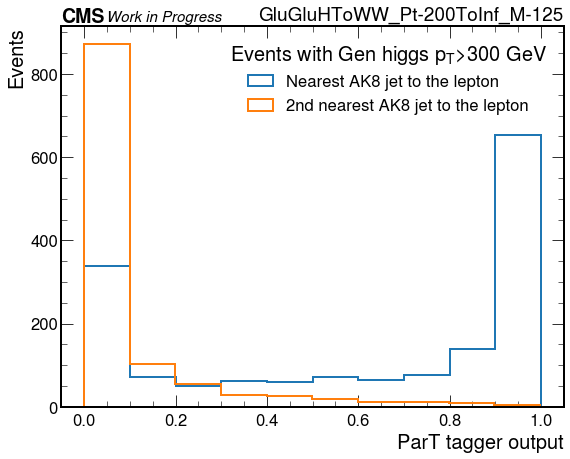

In [503]:
plt.rcParams.update({"font.size": 20})

label_dict = {
    "fatjet0": "Nearest AK8 jet to the lepton",
    "fatjet1": "2nd nearest AK8 jet to the lepton"
}

fig, ax = plt.subplots(figsize=(9, 7))

lep_inside_jet_events = (higgs.pt>300)[events_with_candidatefj]

for fatjet in ParT_noreg_hww_score:
    ax.hist(ParT_noreg_hww_score[fatjet][lep_inside_jet_events], label=label_dict[fatjet], histtype="step", linewidth=2)

ax.legend(title=r"Events with Gen higgs $p_T$>300 GeV")
ax.set_ylabel(r"Events"); 
ax.set_xlabel(r"ParT tagger output");
hep.cms.lumitext(
    "GluGluHToWW_Pt-200ToInf_M-125", ax=ax, fontsize=20
)
hep.cms.text("Work in Progress", ax=ax, fontsize=15)
# ax.set_yscale("log")

plt.savefig(f"/Users/fmokhtar/Desktop/hww/ParT_1st_and_2nd_fj_higgs_pt_300.pdf", bbox_inches='tight')

(array([3.935e+03, 0.000e+00, 0.000e+00, 1.627e+03, 0.000e+00, 0.000e+00,
        5.000e+01, 0.000e+00, 0.000e+00, 3.000e+00]),
 array([0. , 0.3, 0.6, 0.9, 1.2, 1.5, 1.8, 2.1, 2.4, 2.7, 3. ]),
 <BarContainer object of 10 artists>)

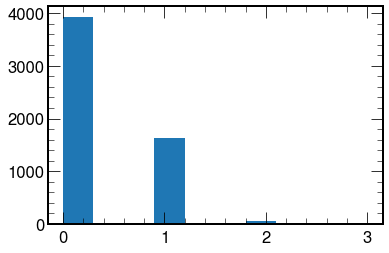

In [905]:
plt.hist(candidatefj_indx[events_with_candidatefj])

## Back to this plot

In [945]:
tagged_jets_indx = []
for ijet in range(sum(events_with_candidatefj)):
    x = np.nan_to_num(ParT_noreg_hww_score["fatjet0"])[ijet]
    y = np.nan_to_num(ParT_noreg_hww_score["fatjet1"])[ijet]
    
    # recall the tagged jets are fed as a subset of all events (only`events_with_candidatefj`)
    # we need to use appropriate indexing
    if x >= y:
        tagged_jets_indx.append([candidatefj_indx[events_with_candidatefj][ijet][0]])    # [0] just picks the value
    else:
        tagged_jets_indx.append([second_fj_indx[events_with_candidatefj][ijet][0]])
        
tagged_jets_indx = ak.Array(tagged_jets_indx)
tagged_jets_indx

<Array [[0], [0], [0], ... [0], [0], [0]] type='5615 * var * int64'>

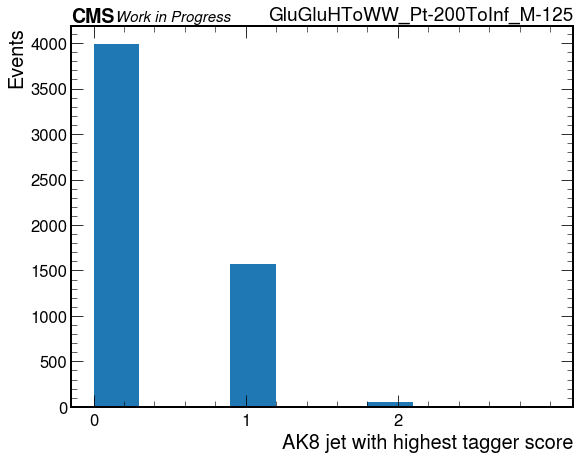

In [949]:
from matplotlib.colors import LogNorm
fig, ax = plt.subplots(figsize=(9, 7))

plt.hist(tagged_jets_indx)
           
ax.set_xticks([0,1,2])

# ax.set_xlim(40,400)
# ax.set_ylim(0,10)
ax.set_xlabel(r"AK8 jet with highest tagger score");
ax.set_ylabel(r"Events");
hep.cms.lumitext(
    "GluGluHToWW_Pt-200ToInf_M-125", ax=ax, fontsize=20
)
hep.cms.text("Work in Progress", ax=ax, fontsize=15)
# ax.set_yscale("log")
plt.savefig(f"/Users/fmokhtar/Desktop/hww/AK8_jet_with_highest_tagger_score.pdf", bbox_inches='tight')

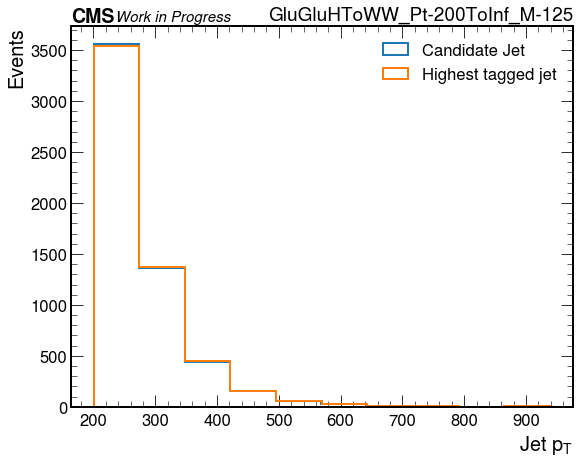

In [951]:
fig, ax = plt.subplots(figsize=(9, 7))

highest_tagged_fj = ak.firsts(good_fatjets[events_with_candidatefj][tagged_jets_indx])

plt.hist(ak.flatten(candidatefj, axis=0).pt, label=r"Candidate Jet", histtype="step", linewidth=2)
plt.hist(highest_tagged_fj.pt, label=r"Highest tagged jet", histtype="step", linewidth=2)

ax.legend()
# ax.set_xlim(40,400)
# ax.set_ylim(0,10)
ax.set_xlabel(r"Jet $p_T$");
ax.set_ylabel(r"Events");
hep.cms.lumitext(
    "GluGluHToWW_Pt-200ToInf_M-125", ax=ax, fontsize=20
)
hep.cms.text("Work in Progress", ax=ax, fontsize=15)
# ax.set_yscale("log")
plt.savefig(f"/Users/fmokhtar/Desktop/hww/candidate_jet_vs_tagged_jet.pdf", bbox_inches='tight')

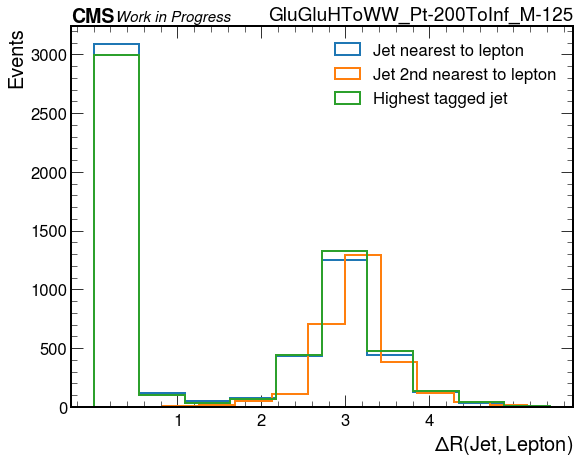

In [952]:
from matplotlib.colors import LogNorm
fig, ax = plt.subplots(figsize=(9, 7))

plt.hist(ak.flatten(candidatelep_p4.delta_r(candidatefj), axis=0), label=r"Jet nearest to lepton", histtype="step", linewidth=2)
plt.hist(ak.flatten(candidatelep_p4.delta_r(second_fj), axis=0), label=r"Jet 2nd nearest to lepton", histtype="step", linewidth=2)
plt.hist(highest_tagged_fj.delta_r(candidatelep[events_with_candidatefj]), label=r"Highest tagged jet", histtype="step", linewidth=2)

ax.set_xticks([1,2,3,4])
# ax.set_xlim(40,400)
# ax.set_ylim(0,10)
ax.legend()
ax.set_xlabel(r"$\Delta R(Jet,Lepton)$");
ax.set_ylabel(r"Events");
hep.cms.lumitext(
    "GluGluHToWW_Pt-200ToInf_M-125", ax=ax, fontsize=20
)
hep.cms.text("Work in Progress", ax=ax, fontsize=15)
# ax.set_yscale("log")
plt.savefig(f"/Users/fmokhtar/Desktop/hww/1d-deltaR_first_second_and_tagged_jet.pdf", bbox_inches='tight')